# Galaxy vs Quasar

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey.
SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 

#### Tasks

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [63]:
import numpy as np
import pylab as plt
from sklearn.naive_bayes import GaussianNB
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier

In [3]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',',names=True, usecols=(0,1,2,3,4,6), dtype=float, comments='#')
data

array([(18.97213, 18.53676, 18.5828 , 18.34936, 18.29215, 0.5228189 ),
       (19.24592, 17.47646, 16.47817, 16.04472, 15.68851, 0.1228459 ),
       (19.43536, 17.70268, 16.91565, 16.58327, 16.39128, 0.        ),
       ...,
       (18.62718, 17.30876, 16.87371, 16.62399, 16.42296, 0.05442934),
       (19.5514 , 18.27711, 17.62101, 17.21947, 17.03347, 0.1125709 ),
       (18.80772, 17.75751, 17.405  , 17.2165 , 17.12295, 0.04365238)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('z1', '<f8')])

In [6]:
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [4]:
data=np.genfromtxt('galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,6), dtype=float)
data.shape

(50000, 6)

In [5]:
#Extract data in each band and redshifts
u = data[:, 0]
g = data[:, 1]
r = data[:, 2]
i = data[:, 3]
z = data[:, 4]
z1 = data[:, 5]

In [6]:
#Colors
u_g = u-g
g_r = g-r
r_i = r-i
i_z = i-z

In [7]:
labels=np.genfromtxt('galaxyquasar.csv', delimiter=',',skip_header=1,usecols=5,dtype=str)

type = np.empty(shape = labels.size)     #Class labels

for i, label in enumerate(labels):
    if (label == 'GALAXY'): type[i] = 0
    elif (label == 'QSO'): type[i] = 1

(-1.0, 1.0)

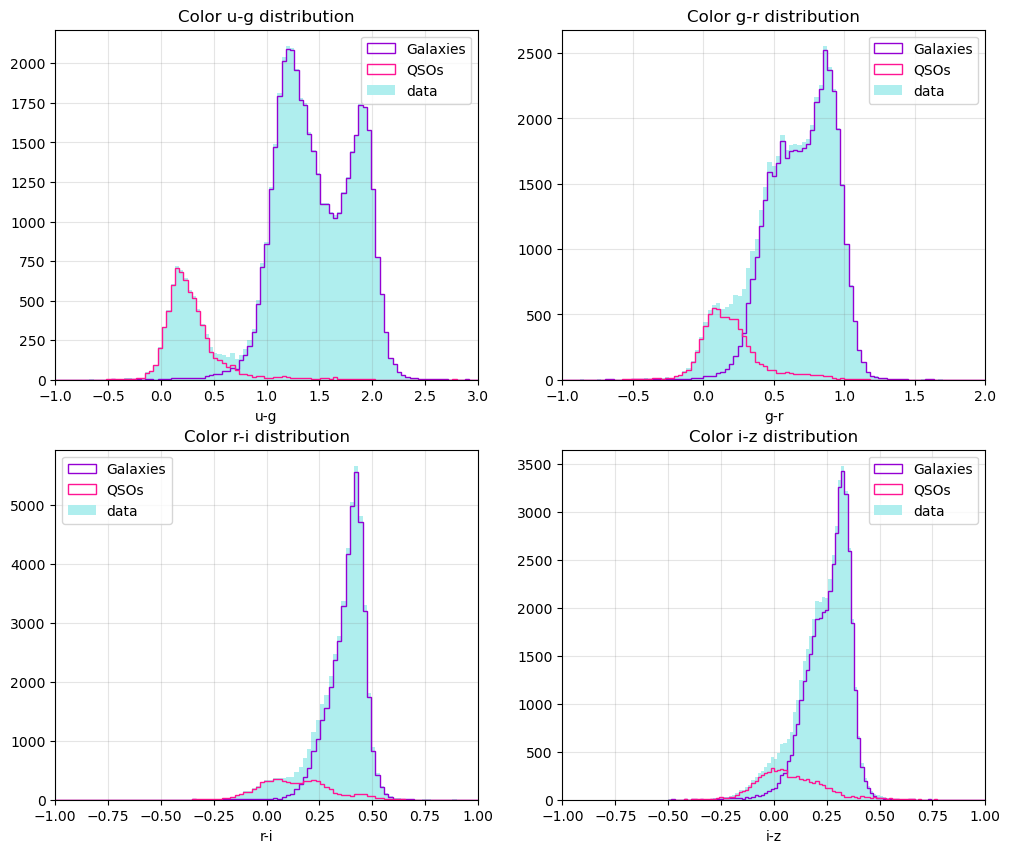

In [102]:
bins = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]

#Plot the distribution of colors for galaxy and QSO
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

#Color g-i
ax[0, 0].hist(u_g[type==0], bins = bins[0], color = 'darkviolet', label = 'Galaxies', histtype = 'step', linewidth = 1)
ax[0, 0].hist(u_g[type==1], bins = bins[0], color = 'deeppink', label = 'QSOs', histtype = 'step', linewidth = 1)
ax[0, 0].hist(u_g, bins = bins[0], color = 'paleturquoise', label = 'data')
ax[0, 0].grid(c='grey', alpha = 0.2)
ax[0, 0].legend()
ax[0, 0].set_xlabel('u-g')
ax[0, 0].set_title('Color u-g distribution')
ax[0, 0].set_xlim(-1, 3)

#Color g-r
ax[0, 1].hist(g_r[type==0], bins = bins[1], color = 'darkviolet', histtype = 'step', linewidth = 1, label = 'Galaxies')
ax[0, 1].hist(g_r[type==1], bins = bins[1], color = 'deeppink', histtype = 'step', linewidth = 1, label = 'QSOs')
ax[0, 1].hist(g_r, bins = bins[1], color = 'paleturquoise', label = 'data')
ax[0, 1].grid(c='grey', alpha = 0.2)
ax[0, 1].legend()
ax[0, 1].set_xlabel('g-r')
ax[0, 1].set_title('Color g-r distribution')
ax[0, 1].set_xlim(-1, 2)

#Color r-i
ax[1, 0].hist(r_i[type==0], bins = bins[2], color = 'darkviolet', histtype = 'step', linewidth = 1, label = 'Galaxies')
ax[1, 0].hist(r_i[type==1], bins = bins[2], color = 'deeppink', histtype = 'step', linewidth = 1, label = 'QSOs')
ax[1, 0].hist(r_i, bins = bins[2], color = 'paleturquoise', label = 'data')
ax[1, 0].grid(c='grey', alpha = 0.2)
ax[1, 0].legend()
ax[1, 0].set_xlabel('r-i')
ax[1, 0].set_title('Color r-i distribution')
ax[1, 0].set_xlim(-1, 1)

#Color i-z
ax[1, 1].hist(i_z[type==0], bins = bins[3], color = 'darkviolet', histtype = 'step', linewidth = 1, label = 'Galaxies')
ax[1, 1].hist(i_z[type==1], bins = bins[3], color = 'deeppink', histtype = 'step', linewidth = 1, label = 'QSOs')
ax[1, 1].hist(i_z, bins = bins[3], color = 'paleturquoise', label = 'data')
ax[1, 1].grid(c='grey', alpha = 0.2)
ax[1, 1].legend()
ax[1, 1].set_xlabel('i-z')
ax[1, 1].set_title('Color i-z distribution')
ax[1, 1].set_xlim(-1, 1)

In [103]:
#Function for plot
def Scatterplot(ax, col1, col2, index1, index2):  # Now accepting 5 parameters
    color = ['darkviolet', 'deeppink']
    ax.scatter(col1[type==0], col2[type==0], label='Galaxies', color=color[0], alpha = 0.3)
    ax.scatter(col1[type==1], col2[type==1], label='QSOs', color=color[1], alpha = 0.3)
    ax.grid(c='grey', alpha=0.2)
    ax.legend()
    ax.set_xlabel(colors_index[index1])
    ax.set_ylabel(colors_index[index2])

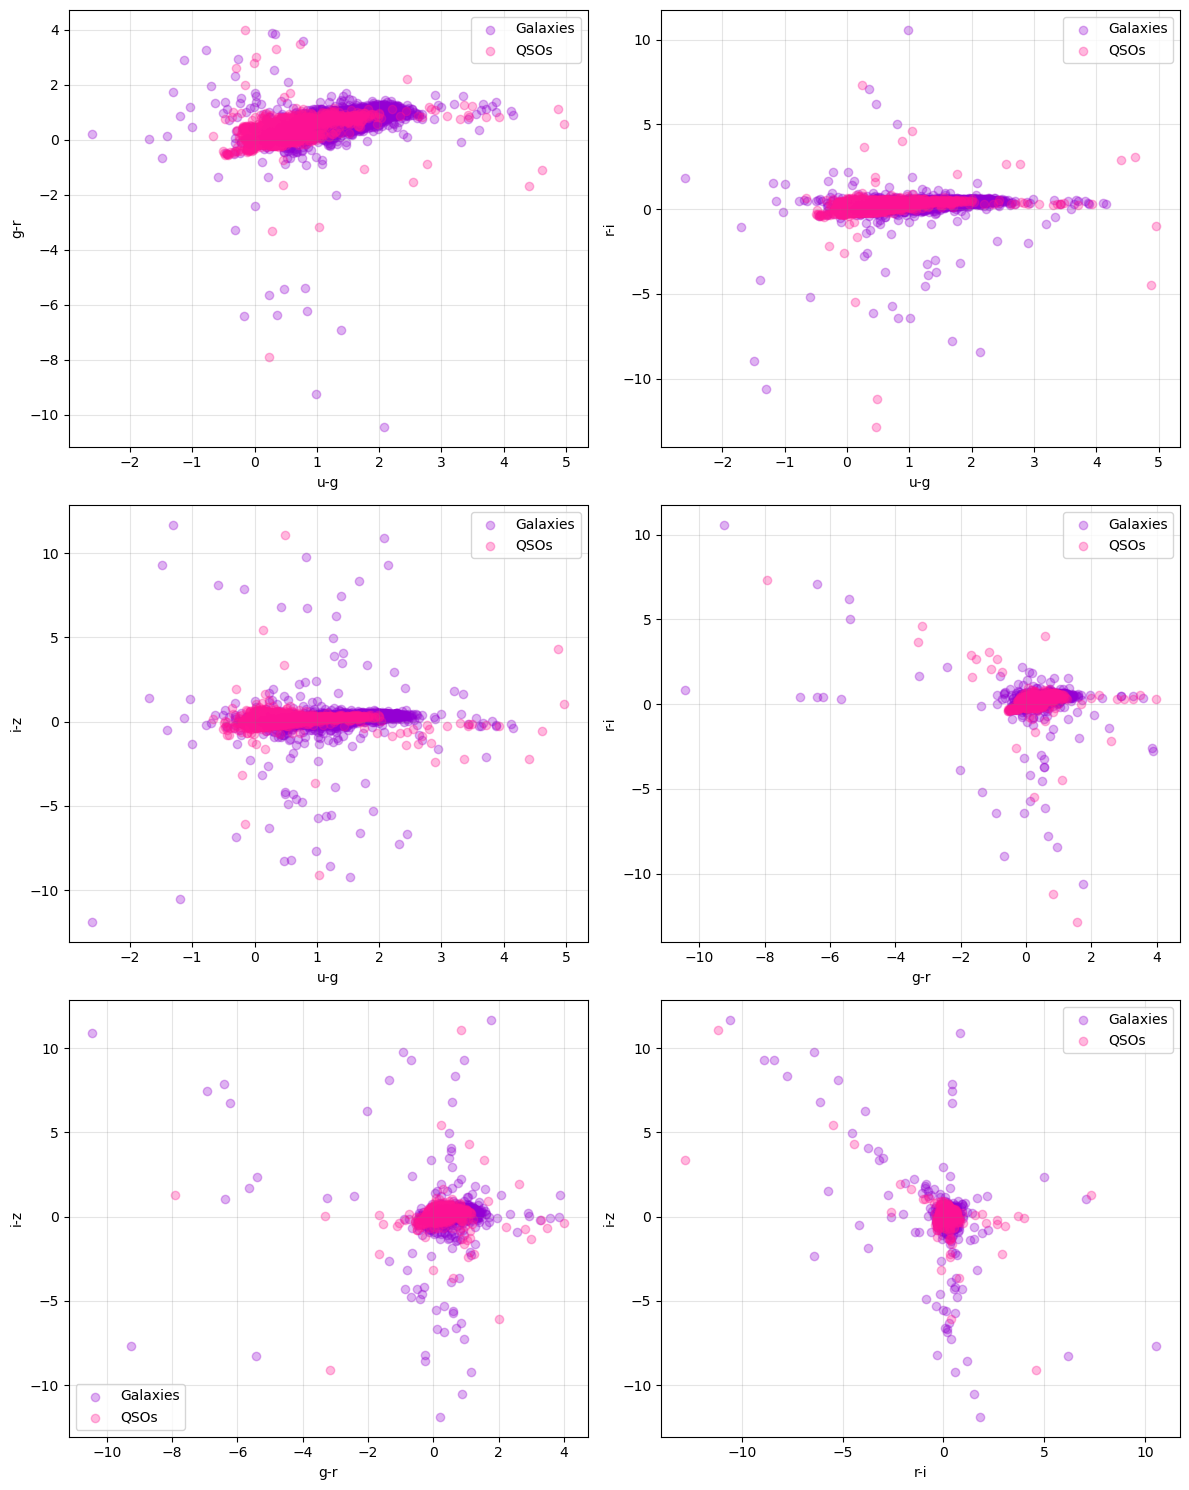

In [104]:
#Now scatter plots for each couple of features
colors = [u_g, g_r, r_i, i_z]
colors_index = ['u-g', 'g-r', 'r-i', 'i-z']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Plot all unique combinations
plot_idx = 0
for i in range(len(colors)-1):
    for j in range(i+1, len(colors)):
        Scatterplot(axes[plot_idx], colors[i], colors[j], i, j)
        plot_idx += 1

plt.tight_layout()
plt.show()

## Gaussian NB

Which is the best feature to use in classification?


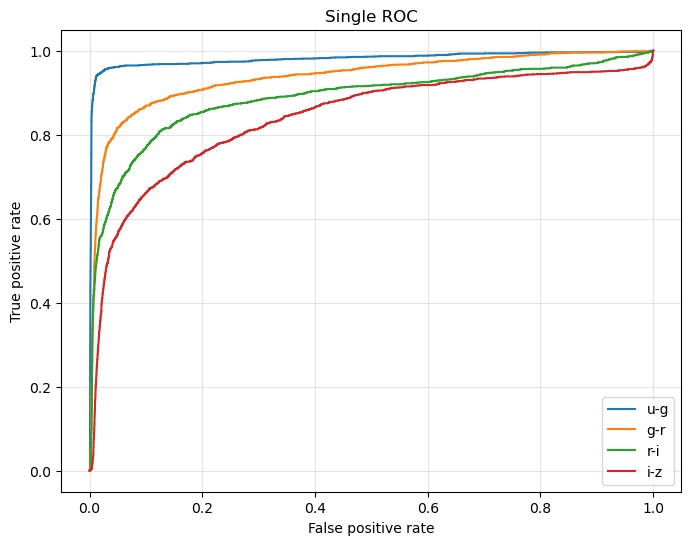

In [31]:
colors = np.array([u_g, g_r, r_i, i_z]).T

#Split data into training & testing sets
(colors_train, colors_test), (type_train, type_test) = split_samples(colors, type, [0.75, 0.25], random_state=0)

plt.figure(figsize=(8, 6))
for i, col in enumerate(colors_index):
    clf = GaussianNB()
    clf.fit(colors_train[:, i].reshape(-1, 1), type_train)
    type_prob = clf.predict_proba(colors_test[:, i].reshape(-1, 1))[:, 1] 
    
    fpr, tpr, thresh = roc_curve(type_test, type_prob)
    plt.plot(fpr, tpr, label=col)
    plt.title('Single ROC')
    plt.legend()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate') 
    plt.grid(c='grey', alpha = 0.2)

The best features is u-g, followed in order by g-r, r-i, i-z. We keep the same order in the GNB. How many features should we consider?

In [28]:
N_tot = len(type)
N_st = np.sum(type == 0)
N_rr = N_tot - N_st
N_train = len(type_train)
N_test = len(type_test)
N_plot = 5000 + N_rr

#Perform Gaussian Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, colors.shape[1] + 1)

order = np.array([1, 0, 2, 3])

type_prob = np.array([])

for nc in Ncolors: #In each cycle we consider different subset of colors and we train for each a new classifier
    clf = GaussianNB()
    clf.fit(colors_train[:, :nc], type_train)
    type_pred = clf.predict(colors_test[:, :nc])
    type_prob = np.append(type_prob, clf.predict_proba(colors_test[:, :nc])[:,1]) #Probability that each example in test set belongs to the quasar class
    classifiers.append(clf)
    predictions.append(type_pred)

completeness, contamination = completeness_contamination(predictions, type_test) #Save the completeness and the contamination for each subset

print("completeness", completeness)
print("contamination", contamination)

# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81), np.linspace(ylim[0], ylim[1], 71)) #Area of data to explore

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()]) #Probability that each point in the grid belongs to the quasar class
Z = Z[:, 1].reshape(xx.shape)

completeness [0.92743764 0.92403628 0.91666667 0.91609977]
contamination [0.06300115 0.1029169  0.10465116 0.11159978]


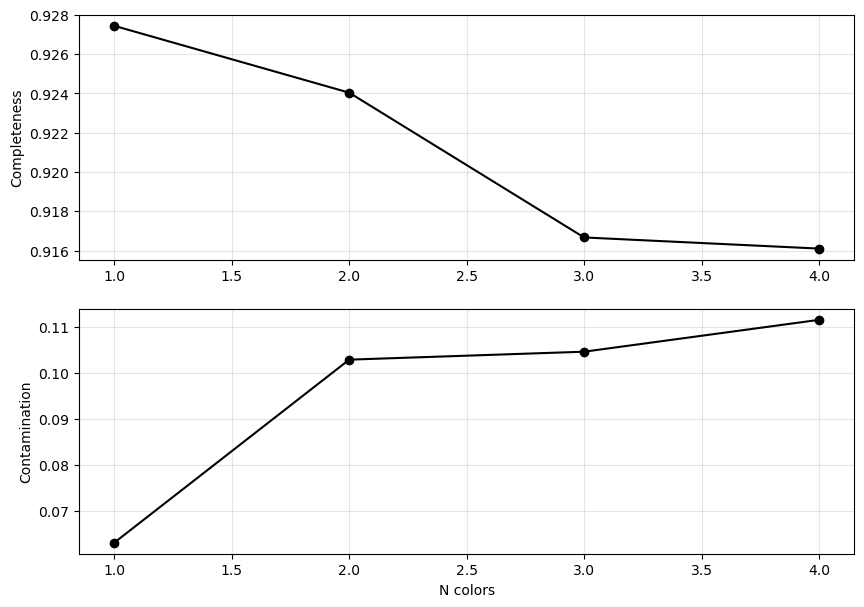

In [23]:
#Plot the results
fig, ax = plt.subplots(2, figsize=(10, 7))

#Plot completeness vs Ncolors
ax[0].plot(Ncolors, completeness, 'o-k', ms=6)
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_ylabel('Completeness')
ax[1].set_xlabel('N colors')

# Plot contamination vs Ncolors
ax[1].plot(Ncolors, contamination, 'o-k', ms=6)
ax[1].set_xlabel('N colors')
ax[1].set_ylabel('Contamination')
ax[1].grid(c='grey', alpha = 0.2)

Th completeness is the rate of true positive and the contamination is the rate of false discovery. From this plot we discover that the best completeness is in the case in which we consider only one feature and we have also the lowest contamination, this is u-g. To confirm, we can also plot the ROC curves with different number of features.

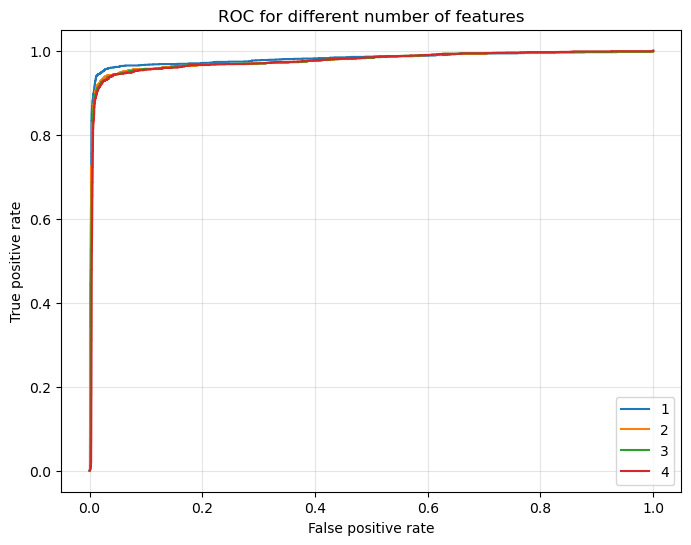

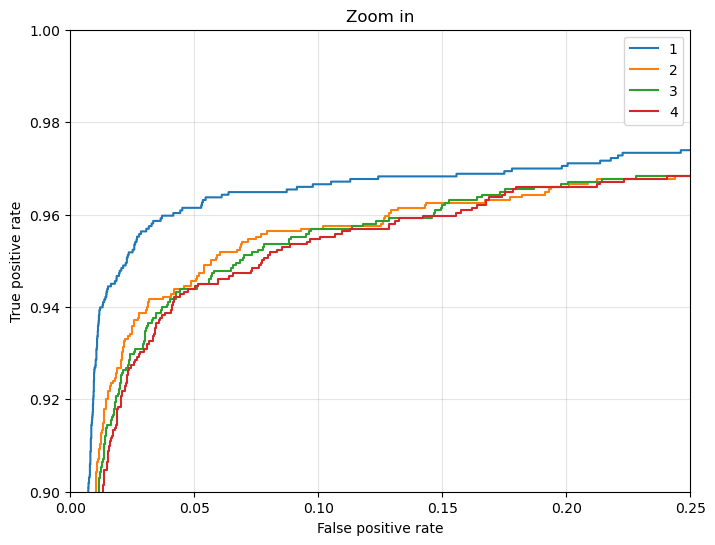

In [61]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.gca()

for i in range(4): #In each cycle we consider different subset of colors and we train for each a new classifier
    clf = GaussianNB()
    clf.fit(colors_train[:, 0:i+1], type_train)
    type_prob = clf.predict_proba(colors_test[:, 0:i+1])[:, 1] 
    
    fpr, tpr, thresh = roc_curve(type_test, type_prob)
    
    ax = fig.gca()
    ax.grid(c='grey', alpha = 0.2)
    ax.set_title('ROC for different number of features')
    ax.plot(fpr, tpr, label=i+1)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend()

    ax2.grid(c='grey', alpha = 0.2)
    ax2.set_title('Zoom in')
    ax2.plot(fpr, tpr, label=i+1)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend()
    ax2.set_xlim(0, 0.25)
    ax2.set_ylim(0.9, 1) 

This confirm what we have already discovered.

## Quadratic Discriminant Analysis

We will do the same with a different method.

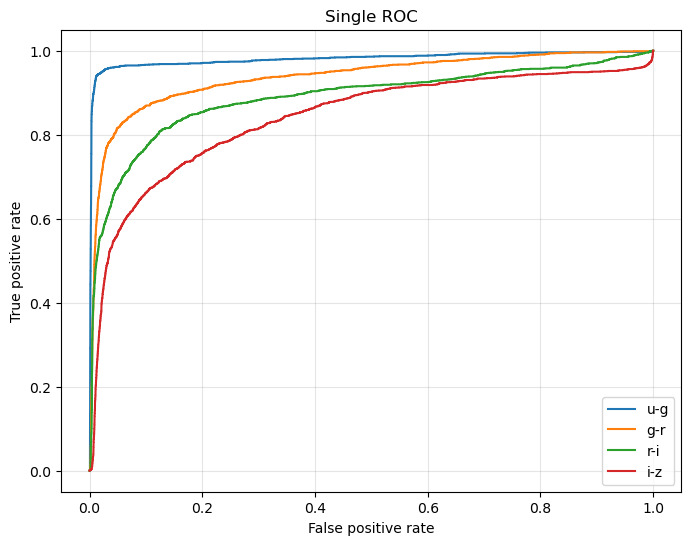

In [62]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(colors_index):
    qda = QDA()
    qda.fit(colors_train[:, i].reshape(-1, 1), type_train)
    type_prob = qda.predict_proba(colors_test[:, i].reshape(-1, 1))[:, 1] 
    
    fpr, tpr, thresh = roc_curve(type_test, type_prob)
    plt.plot(fpr, tpr, label=col)
    plt.title('Single ROC')
    plt.legend()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate') 
    plt.grid(c='grey', alpha = 0.2)

Again the most informative feature is u-g.

In [56]:
N_tot = len(type)
N_st = np.sum(type == 0)
N_rr = N_tot - N_st
N_train = len(type_train)
N_test = len(type_test)
N_plot = 5000 + N_rr

#Perform QDA
classifiers = []
predictions = []
Ncolors = np.arange(1, colors.shape[1] + 1)

type_prob = np.array([])

for nc in Ncolors: #In each cycle we consider different subset of colors and we train for each a new classifier
    qda = QDA()
    qda.fit(colors_train[:, :nc], type_train)
    type_pred = qda.predict(colors_test[:, :nc])
    type_prob = np.append(type_prob, qda.predict_proba(colors_test[:, :nc])[:,1]) #Probability that each example in test set belongs to the quasar class
    classifiers.append(qda)
    predictions.append(type_pred)

completeness, contamination = completeness_contamination(predictions, type_test) #Save the completeness and the contamination for each subset

print("Completeness", completeness)
print("Contamination", contamination)

Completeness [0.92743764 0.93027211 0.92687075 0.92573696]
Contamination [0.06300115 0.0665529  0.0651801  0.06632361]


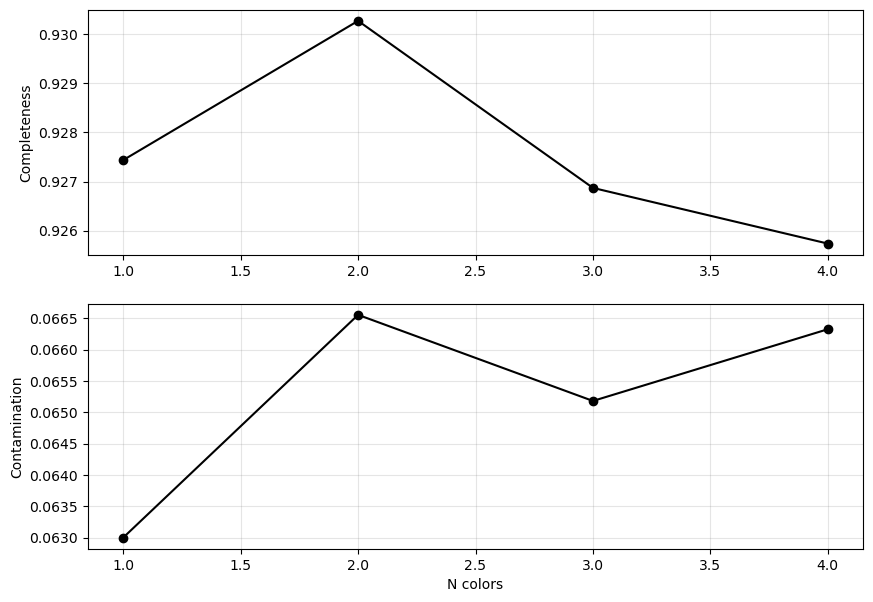

In [57]:
#Plot the results
fig, ax = plt.subplots(2, figsize=(10, 7))

#Plot completeness vs Ncolors
ax[0].plot(Ncolors, completeness, 'o-k', ms=6)
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_ylabel('Completeness')
ax[1].set_xlabel('N colors')

# Plot contamination vs Ncolors
ax[1].plot(Ncolors, contamination, 'o-k', ms=6)
ax[1].set_xlabel('N colors')
ax[1].set_ylabel('Contamination')
ax[1].grid(c='grey', alpha = 0.2)

Here the result is contradictory: the highest completeness is for two feature, while the lowest contamination is for one features. Let's look to the ROC curves.

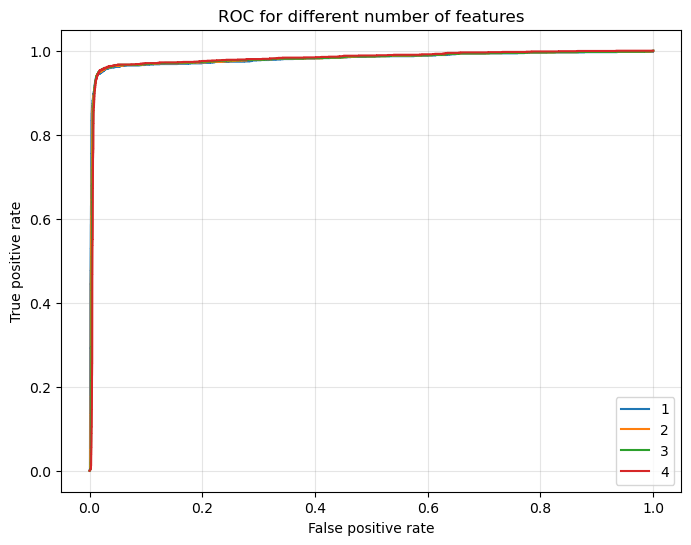

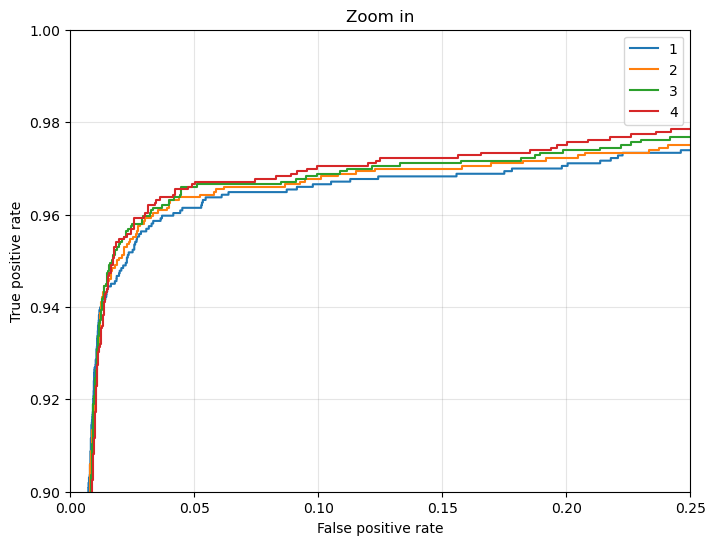

In [60]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.gca()

for i in range(4): #In each cycle we consider different subset of colors and we train for each a new classifier
    qda = QDA()
    qda.fit(colors_train[:, 0:i+1], type_train)
    type_prob = qda.predict_proba(colors_test[:, 0:i+1])[:, 1] 
    
    fpr, tpr, thresh = roc_curve(type_test, type_prob)
    
    ax = fig.gca()
    ax.grid(c='grey', alpha = 0.2)
    ax.set_title('ROC for different number of features')
    ax.plot(fpr, tpr, label=i+1)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend()

    ax2.grid(c='grey', alpha = 0.2)
    ax2.set_title('Zoom in')
    ax2.plot(fpr, tpr, label=i+1)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend()
    ax2.set_xlim(0, 0.25)
    ax2.set_ylim(0.9, 1) 

## commento

## K-Nearest Neighbor Classifier

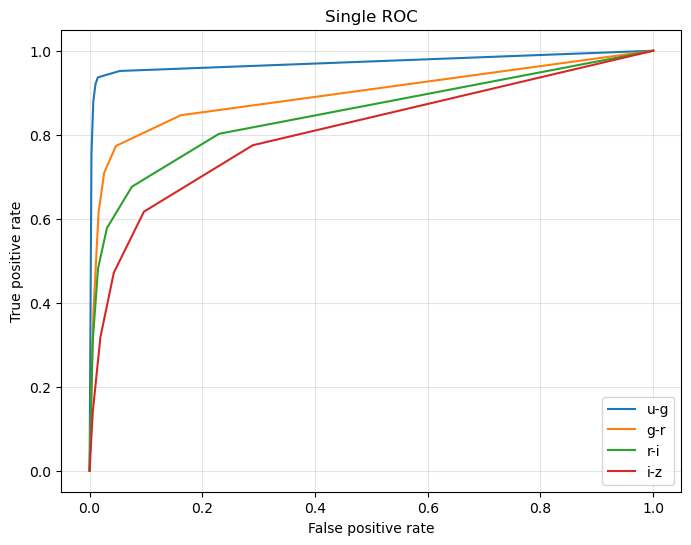

In [64]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(colors_index):
    knc = KNeighborsClassifier(5)
    knc.fit(colors_train[:, i].reshape(-1, 1), type_train)
    type_prob = knc.predict_proba(colors_test[:, i].reshape(-1, 1))[:, 1] 
    
    fpr, tpr, thresh = roc_curve(type_test, type_prob)
    plt.plot(fpr, tpr, label=col)
    plt.title('Single ROC')
    plt.legend()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate') 
    plt.grid(c='grey', alpha = 0.2)

Again the best features is u-g. 

In [65]:
N_tot = len(type)
N_st = np.sum(type == 0)
N_rr = N_tot - N_st
N_train = len(type_train)
N_test = len(type_test)
N_plot = 5000 + N_rr

#Perform QDA
classifiers = []
predictions = []
Ncolors = np.arange(1, colors.shape[1] + 1)

type_prob = np.array([])

for nc in Ncolors: #In each cycle we consider different subset of colors and we train for each a new classifier
    knc = KNeighborsClassifier(5)
    knc.fit(colors_train[:, :nc], type_train)
    type_pred = knc.predict(colors_test[:, :nc])
    type_prob = np.append(type_prob, knc.predict_proba(colors_test[:, :nc])[:,1]) #Probability that each example in test set belongs to the quasar class
    classifiers.append(qda)
    predictions.append(type_pred)

completeness, contamination = completeness_contamination(predictions, type_test) #Save the completeness and the contamination for each subset

print("Completeness", completeness)
print("Contamination", contamination)

Completeness [0.92063492 0.92176871 0.93367347 0.93764172]
Contamination [0.06505469 0.05848292 0.05126728 0.03837209]


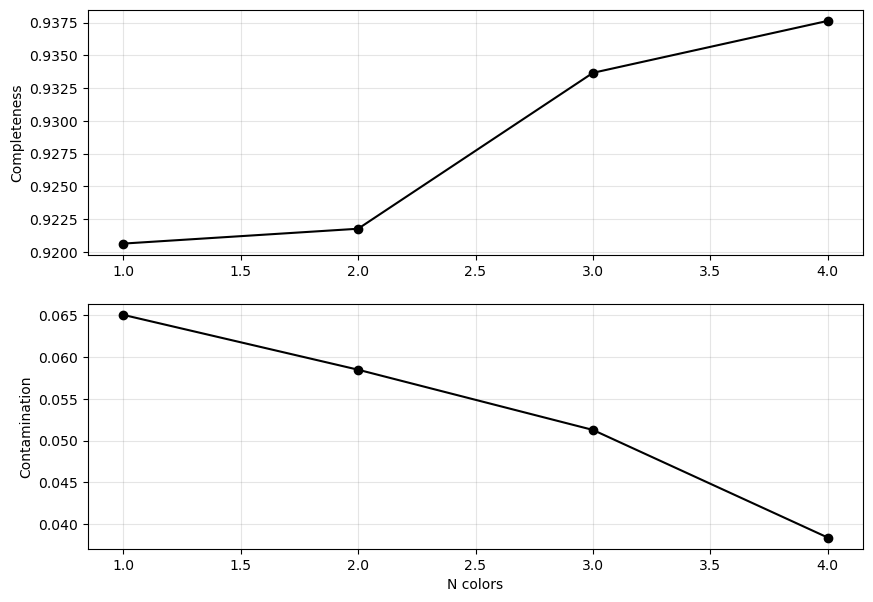

In [66]:
#Plot the results
fig, ax = plt.subplots(2, figsize=(10, 7))

#Plot completeness vs Ncolors
ax[0].plot(Ncolors, completeness, 'o-k', ms=6)
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_ylabel('Completeness')
ax[1].set_xlabel('N colors')

# Plot contamination vs Ncolors
ax[1].plot(Ncolors, contamination, 'o-k', ms=6)
ax[1].set_xlabel('N colors')
ax[1].set_ylabel('Contamination')
ax[1].grid(c='grey', alpha = 0.2)

Now the new method shows that the best completeness and the smallest contamination is for four features.  

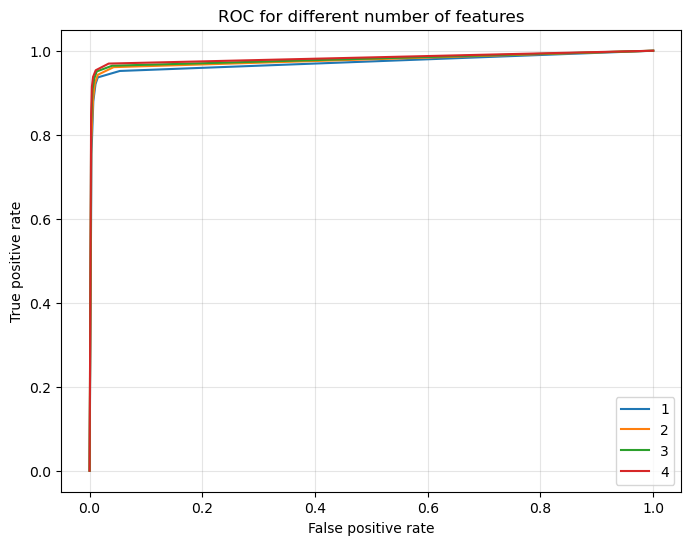

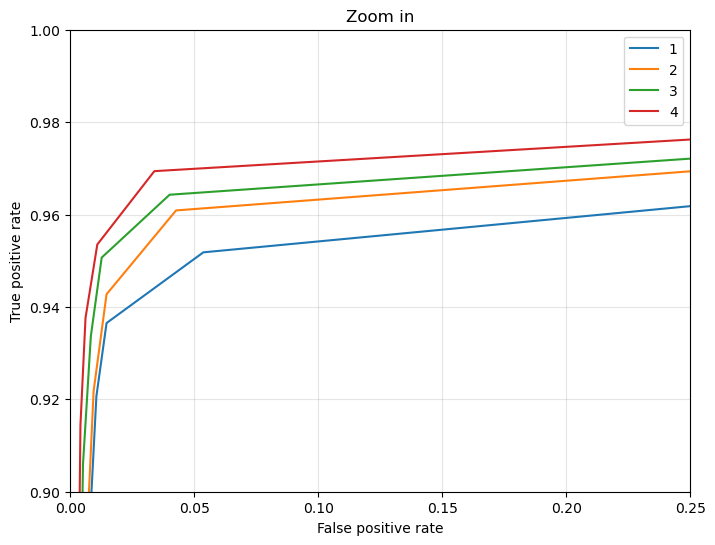

In [67]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.gca()

for i in range(4): #In each cycle we consider different subset of colors and we train for each a new classifier
    knc = KNeighborsClassifier(5)
    knc.fit(colors_train[:, 0:i+1], type_train)
    type_prob = knc.predict_proba(colors_test[:, 0:i+1])[:, 1] 
    
    fpr, tpr, thresh = roc_curve(type_test, type_prob)
    
    ax = fig.gca()
    ax.grid(c='grey', alpha = 0.2)
    ax.set_title('ROC for different number of features')
    ax.plot(fpr, tpr, label=i+1)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend()

    ax2.grid(c='grey', alpha = 0.2)
    ax2.set_title('Zoom in')
    ax2.plot(fpr, tpr, label=i+1)
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend()
    ax2.set_xlim(0, 0.25)
    ax2.set_ylim(0.9, 1) 

This is confirmed by the ROC curves.